# COMP5623 Coursework on Image Caption Generation

Starter code.



## Text preparation 

We need to build a vocabulary.

samaneh ghelichkhani /
student id: 201285355

In [0]:
# Mounted Drive if using Colab; otherwise, your local path
root = "drive/My Drive/data/" # <--- replace this with your root data directory
caption_dir = root + "/Flickr8k_text/"                       # <--- replace these too
image_dir = root + "/Flicker8k_Dataset/"                           # <---


token_file = "Flickr8k.token.txt"

A helper function to read in our ground truth text file.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:

In [0]:
lines = read_lines(caption_dir + token_file)

In [5]:
lines[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [0]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


In [0]:
import itertools
from collections import Counter
words = []
words_split = []
for i in range(len(lines)):
  lines[i] = lines[i].replace('.', '') # Fullstops
  lines[i] = lines[i].replace(',', '') # Commas
  words.append(lines[i].lower().split())
  words_split.append(lines[i].lower().split())

words = list(itertools.chain.from_iterable(words))
word_count = dict(Counter(words))

del_list = []
for key in word_count:
  if word_count[key] <= 3 and 'jpg' not in key:
    del_list.append(key)

for word in words:
  if word in del_list:
    words.remove(word)

In [8]:
len(words)

469748

In [0]:

image_ids = []
del_ids = []

for i in range(len(words_split)):
  del_ids.append(words_split[i][0])
  img = words_split[i][0][:-5]
  image_ids.append(img)

cleaned_captions = []
captions = words_split
for i in range(len(captions)):
  for del_id in del_ids:
    if del_id in captions[i]:
      captions[i].remove(del_id)
  for del_word in del_list:
    if del_word in captions[i]:
      captions[i].remove(del_word)
  words_join = ' '.join(captions[i])
  cleaned_captions.append(words_join)

In [10]:
len(cleaned_captions)

40460

Build the vocabulary.

In [0]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

Add the rest of the words from the parsed captions:

``` vocab.add_word('new_word')```

Don't add words that appear three times or less.

In [0]:
for word in words:
  if 'jpg' not in word:
    vocab.add_word(word)

In [13]:
print(len(vocab))

3748


## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

The dataframe for the image paths and captions.

In [0]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [0]:
data_df.head(n=5)
data_df = data_df[data_df.path != 'drive/My Drive/Colab Notebooks/data/images/flickr/2258277193_586949ec62j.jpg']

This is the Flickr8k class for the dataset.

In [0]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [0]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [0]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [0]:
unit_size = 5

train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=128, 
    shuffle=True,
    num_workers=0,
    collate_fn=caption_collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=5, 
    shuffle=False,
    num_workers=0,
    collate_fn=caption_collate_fn
)

## Encoder and decoder models

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""

        with torch.no_grad():
          outputs = self.resnet(images)
        outputs = outputs.view(-1, 2048)
        outputs = self.linear(outputs)
        features = self.bn(outputs)

        return features
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        # self.lstm / self.rnn

        # LSTM Layer
        # self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # #RNN Layer
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.rnn(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [22]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Set training parameters.

In [0]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 1

Initialize the models and set the learning parameters.

In [24]:
import numpy as np

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)
print(len(vocab))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth



3748


## Training the model

In [0]:
# encoder.train()
# decoder.train()
# # Train the models
# total_step = len(train_loader)
# for epoch in range(num_epochs):
#     for i, (images, captions, lengths) in enumerate(train_loader):

#         # Set mini-batch dataset
#         images = images.to(device)
#         captions = captions.to(device)

#         # Packed as well as we'll compare to the decoder outputs
#         targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

#         # Forward, backward and optimize
#         features = encoder(images)
#         outputs = decoder(features, captions, lengths)

#         loss = criterion(outputs, targets)
        
#         # Zero gradients for both networks
#         decoder.zero_grad()
#         encoder.zero_grad()
   
#         loss.backward()
#         optimizer.step()

#         # Print log info
#         if i % log_step == 0:
#             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
#                   .format(epoch, num_epochs, i, total_step, loss.item())) 

#         # If you want to save the model checkpoints - recommended once you have everything working
#         # Make sure to save RNN and LSTM versions separately
#         # if (i+1) % save_step == 0:
#     torch.save(decoder.state_dict(),  'decoder{}.ckpt'.format(epoch+1))
#     torch.save(encoder.state_dict(),  'encoder{}.ckpt'.format(epoch+1))
    # Encoder = torch.load('drive/My Drive/Colab Notebooks/RNN/decoder1.ckpt')

In [0]:

# images, captions, lengths = [x[0] for x in iter (test_loader).next()]


# def generate_caption(image):
#     trans = transforms.ToPILImage()
#     image = trans(image)
#     image = image.resize([224, 224], Image.LANCZOS)
#     image = data_transform(image).unsqueeze(0)

#     encoder.eval()

#     image = image.to(device)

#     # Generate a caption from the image
#     feature = encoder(image)
#     sampled_ids = decoder.sample(feature)
#     sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

#     # Convert word_ids to words
#     sampled_caption = []
#     for word_id in sampled_ids:
#         word = vocab.idx2word[word_id]
#         sampled_caption.append(word)
#         if word == '<end>':
#             break
#     sentence = ' '.join(sampled_caption[1:-1])

#     return sentence
      


In [0]:
images, captions, lengths = [x[0] for x in iter (test_loader).next()]

def display_image(display_image):
    tensor_image = display_image + 1
    tensor_image = tensor_image - tensor_image.min()
    picture = tensor_image / (tensor_image.max() - tensor_image.min())

    plt.imshow(picture.permute(1, 2, 0))
    plt.axis("off")
    

Candidate
['poster', 'laptops', 'supervise', 'footballer', 'handstand', 'streets', 'pauses', 'dune', 'laugh', 'arms', 'mixing', 'desert', 'cleaning', 'couple', 'leather', 'cricket', 'clouds', 'hut', 'reeds', 'kick']
Reference
['<start>', 'a', 'young', 'girl', 'is', 'playing', 'with', 'a', 'soccer', 'ball', 'in', 'the', 'grass', '<end>', '<pad>', '<pad>', '<pad>', '<pad>']
blue_score:
0


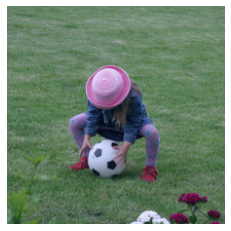

In [27]:

from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import numpy as np

sample_image = []
sample_caption = []
predicted_caption = []
temp_images = []
temp_captions = []
encoder.eval()
decoder.eval()
for (images, captions, lengths) in test_loader:
  #print(images)
  temp_images.append(images)
  #sample_image = images[4]
  temp_captions.append(captions)
  #sample_caption = captions[4]
  #break
sample_image = temp_images[2][2]
sample_caption = temp_captions[2][2]
sample_image = sample_image.to(device)
sample_caption = sample_caption.cpu()
# print("Sample caption", type(sample_caption))
features = encoder(images.to(device))
wordIDs = decoder.sample(features)
# print ("Eord Id:",type(wordIDs))
caption = decoder.sample(features).cpu().detach().numpy()
for word in caption[0]:
  predicted_caption.append(vocab.idx2word[word])

display_image(sample_image.cpu())
# plt.figure()
# plt.imshow(sample_image.cpu().permute(1, 2, 0))
# plt.show()

# print(wordIDs[:1].tolist().squeeze(1))
# print(np.array(wordIDs.cpu()[:1]).squeeze(0))
newcaption = np.array(wordIDs.cpu()[:1]).squeeze(0)
# print ("Predicted caption tensors ", type(newcaption))
candidate_caption = [vocab.idx2word[word] for word in newcaption]
print("Candidate")
print(predicted_caption)
#print(sample_caption)
sample_caption = sample_caption.cpu().squeeze(0).tolist()
actual_caption = [vocab.idx2word[word] for word in sample_caption]
print("Reference")
print(actual_caption)

score = sentence_bleu(actual_caption, sample_caption)
print("blue_score:\n" + str(score))


THE MODELS WOULD BE SAVED NOW. USING THE SAVED MODELS FOR TESTING NOW.




['encoder1.ckpt', 'decoder1.ckpt', 'decoder2.ckpt', 'encoder2.ckpt', 'encoder3.ckpt', 'decoder3.ckpt', 'decoder4.ckpt', 'encoder4.ckpt', 'encoder5.ckpt', 'decoder5.ckpt']


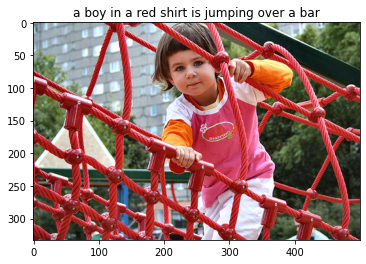

In [29]:
import os

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image


transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.485, 0.456, 0.406), 
                                                    (0.229, 0.224, 0.225))])

all_models = os.listdir('/content/drive/My Drive/RNN/')
#all_models.sort()
print(all_models)
test_encoder = EncoderCNN(embed_size).to(device)
test_decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# THERE ARE LSTM 12 FILES AND RNN 12 FILES IN THE GOOGL DRIVE SAVED AFTER TRAINING
checkpoint_decoder = torch.load('/content/drive/My Drive/RNN/decoder5.ckpt') 
checkpoint_encoder = torch.load('/content/drive/My Drive/RNN/encoder5.ckpt') 
file_decoder = '1'
file_encoder = '/content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt'
# NOW LOAD THE CHECKPOINTS TO THE MODELS
test_encoder.load_state_dict(checkpoint_encoder)
test_decoder.load_state_dict(checkpoint_decoder)

# SETTING THE MODELS TO EVAL MODE
test_encoder.eval()
test_decoder.eval()

test_image = load_image(image_dir + "1007320043_627395c3d8.jpg", transform)
test_image = test_image.to(device)

sample_feature = test_encoder(test_image)
sampled_ids = test_decoder.sample(sample_feature)
sampled_ids = sampled_ids[0].cpu().numpy()

test_image = Image.open(image_dir + "1007320043_627395c3d8.jpg")

sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption[1:-1])

plt.title(sentence)
plt.imshow(test_image)

In [30]:

from nltk.translate.bleu_score import sentence_bleu
reference = ['A', 'child', 'playing', 'on', 'a', 'rope', 'net'],
['A', 'little', 'girl', 'climbing', 'on', 'red', 'roping'],
['A', 'little', 'girl', 'in', 'pink', 'climbs', 'a', 'rope', 'bridge', 'at', 'the', 'park']
['A', 'small', 'child', 'grips', 'onto', 'the', 'red', 'ropes', 'at', 'the', 'playground']
['The', 'small', 'child', 'climbs', 'on', 'a', 'red', 'ropes', 'on', 'a', 'playground']
candidate = ['a', 'man', 'in', 'a', 'black', 'shirt', 'is', 'standing','on', 'a', 'bench']
score = sentence_bleu(reference, candidate)
print("bleu_score:\n" + str(score))

bleu_score:
0.36720562698935927


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
def get_sentence(caption_tensor): 
    # Convert word_ids to words
    sampled_caption = []
    for word_id in caption_tensor:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption[1:-1])
    return sentence

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


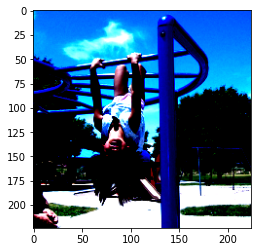

Bleu Score 0.8003203203844999
Predicted Sentence a little boy is jumping on a trampoline


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


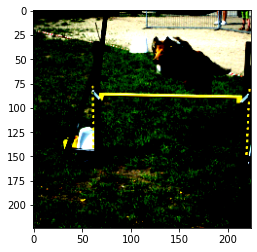

Bleu Score 0.8491821094987799
Predicted Sentence a dog leaps over a hurdle


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


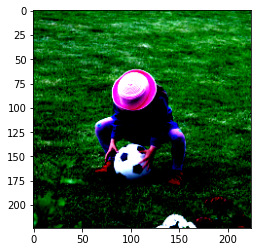

Bleu Score 0.7516200388933441
Predicted Sentence a small child is running through a grassy field


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


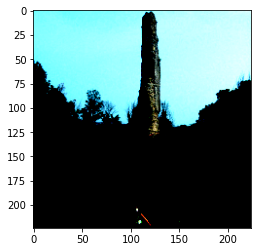

Bleu Score 0.6883338880800094
Predicted Sentence a man is standing on a ledge next to a large tree


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


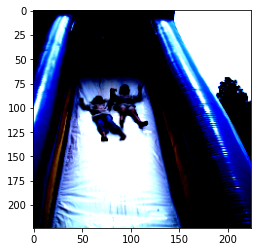

Bleu Score 0.7598356856515925
Predicted Sentence a child slides down a slide into a pool


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


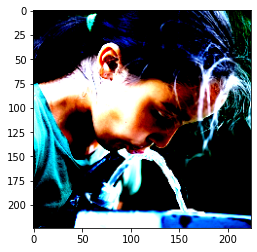

Bleu Score 0.721634009677548
Predicted Sentence a young girl wearing a pink hat and a blue shirt is smiling


IndexError: ignored

In [36]:
blue_scores = []
for i, (images, targets, lengths) in enumerate(test_loader): # Iterating the test data loader
  image = images.to(device)
  #image_features = encoder(image)
  test_encoder.eval()
  test_decoder.eval()

#test_image = load_image(image_dir + "1007320043_627395c3d8.jpg", transform)
#test_image = test_image.to(device)
  print ("Epoch", file_encoder)
  sample_feature = test_encoder(image)
  sampled_ids = test_decoder.sample(sample_feature)
  sampled_ids = sampled_ids[0].cpu().numpy()
  #sampled_ids = decoder.sample(image_features) 
  #sampled_ids = sampled_ids[0].cpu().data.numpy()
  referenced_ids = targets[0].cpu().data.numpy()
  reference_sentence = get_sentence(referenced_ids)
  predicted_sentence = get_sentence(sampled_ids)
  bleu_score = sentence_bleu(reference_sentence, predicted_sentence)
  blue_scores.append(bleu_score)
  

  #Displaying image
  img = image.cpu().numpy()
  plt.imshow(np.transpose(img[0], (1,2,0)))
  plt.show()
  print("Bleu Score",bleu_score)
  #print("Actual Sentence",reference_sentence)
  print("Predicted Sentence",predicted_sentence)
  if i in img[i] <= [5]:
    break

LONG caption


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


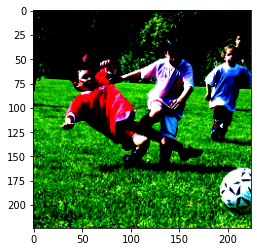

Actual Sentence the boy with the red soccer suit is falling down while the boy in the white shirt has his eyes on the ball
Predicted Sentence a boy in a blue and white uniform is playing a baseball game
Bleu Score 0.7400828044922853


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


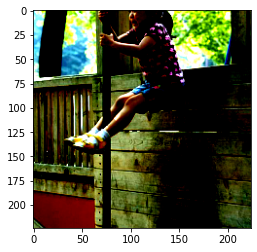

Actual Sentence a small child with a ponytail dressed in jean shorts and a pink and brown shirt climbs on a pole near wooden playground equipment
Predicted Sentence a little girl in a pink shirt and blue jeans is jumping in the air
Bleu Score 0.7226568811456053
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


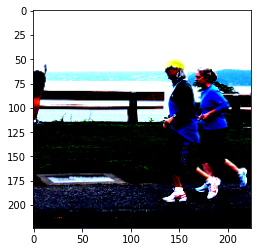

Actual Sentence two women jogging down a sidewalk in front of a person leaning on a bench in front of a lake with another person
Predicted Sentence a man and woman sit on a bench outside
Bleu Score 0.7790872728179328
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


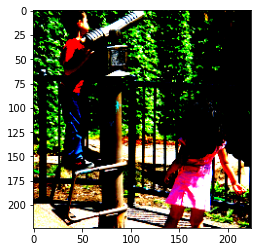

Actual Sentence a little boy uses a telescope to view an object far away while a little girl stands nearby and watches
Predicted Sentence a boy is jumping into a pool
Bleu Score 0.8408964152537145
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


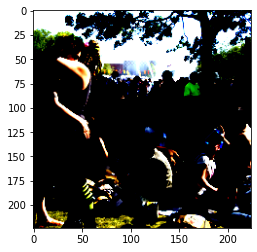

Actual Sentence a group of people is gathered in front of fountains while a couple wearing leather outfits are in an embrace
Predicted Sentence a group of people are standing in a crowd of people
Bleu Score 0.7598356856515925
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


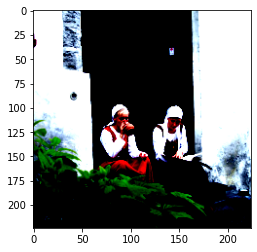

Actual Sentence two women with white head garb and long dresses sitting in front of a door on steps reading and drinking a beverage
Predicted Sentence a man and woman sit on a bench outside of a building
Bleu Score 0.7447819789879647
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


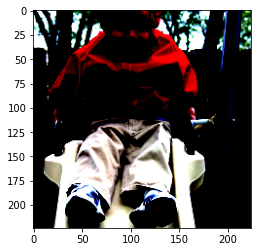

Actual Sentence the little boy in the red coat and tan pants is at the top of the slide holding on to the handles of the slide
Predicted Sentence a child in a red shirt is jumping over a bar
Bleu Score 0.7765453555044466
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /cont

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


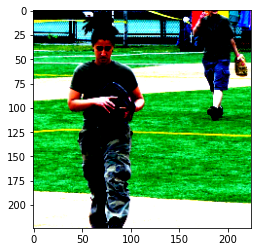

Actual Sentence a woman in camouflage and her hair up in a ponytail walks on the field with a black softball glove on one hand
Predicted Sentence a boy hits a tennis ball on a court
Bleu Score 0.8091067115702212
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


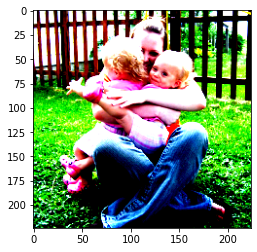

Actual Sentence a woman wearing jeans and brown flip flops holding two blonde hair toddler girls wearing pink shorts and shoes
Predicted Sentence two small children playing in a sprinkler
Bleu Score 0.8024468307724723
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


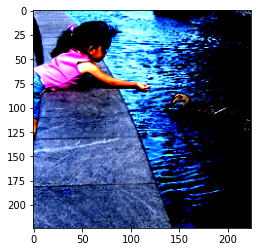

Actual Sentence a little girl dressed in a pink shirt blue shorts and a pink hair ribbon feeding ducks that are swimming in water
Predicted Sentence a boy and girl are playing in a pool
Bleu Score 0.7598356856515925
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


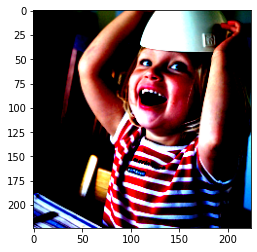

Actual Sentence a smiling blonde girl with a red striped shirt is sitting in a chair at a table with a white bowl on her head
Predicted Sentence a young girl wearing a pink hat and a pink hat
Bleu Score 0.7427498127683173
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


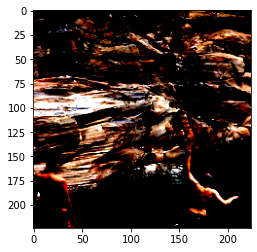

Actual Sentence one boy in orange shorts standing on a rock cliff over water while the other boy in black shorts jumps off into the water
Predicted Sentence a man and a woman are playing in a lake
Bleu Score 0.7875110621102679
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


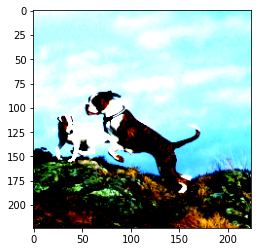

Actual Sentence two brown and white dogs one a boxer and the other a terrier play on a rock covered hill with a blue sky and clouds in the background
Predicted Sentence a dog is running through the grass
Bleu Score 0.7863503941633413
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


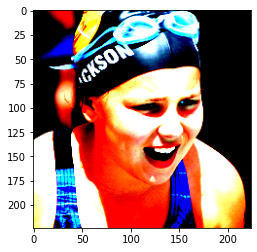

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Sentence a young girl is wearing a blue patterned swimsuit a black and yellow swim cap and has blue swim goggles on her head
Predicted Sentence a young girl wearing a pink hat and blue jeans is standing in a puddle of water slide
Bleu Score 0.6875965181003809


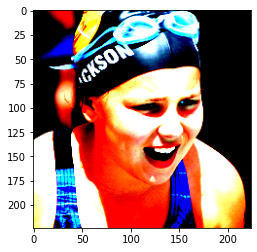

Actual Sentence a young female wearing a swimsuit goggles and swimming cap looking in front of her with an open mouth
Predicted Sentence a young girl wearing a pink hat and blue jeans is standing in a puddle of water slide
Bleu Score 0.6875965181003809
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Noteboo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


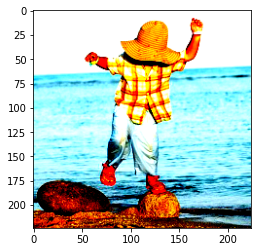

Actual Sentence lady with straw hat covering face and head standing on a rock in front of the ocean wearing red sandals
Predicted Sentence a boy in a blue bathing suit is jumping into a pool
Bleu Score 0.6964705665515708
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


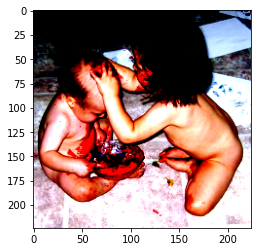

Actual Sentence a naked baby and toddler on the floor covered in paint the toddler putting her hands on the baby 's head
Predicted Sentence a baby crawls on a couch
Bleu Score 0.8408964152537145
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


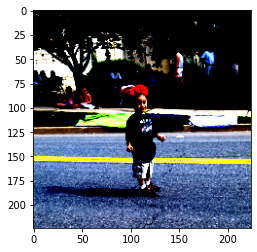

Actual Sentence a little child stands in the middle of the street wearing a large red hat while people sit on the grass
Predicted Sentence a young girl wearing a pink shirt is running on a sidewalk
Bleu Score 0.7131252538759287
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


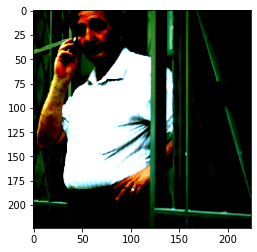

Actual Sentence a man wearing a white shirt is standing in a doorway surrounded by green bars and his holding a cellphone up to his right ear
Predicted Sentence a man in a blue shirt and a woman in a pink dress
Bleu Score 0.7674731847914632
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


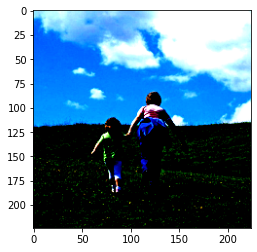

Actual Sentence a woman with her sweatshirt tied around her waist holding hands with a young girl in a green shirt as they walk up a grassy hill
Predicted Sentence two children are playing in a sprinkler
Bleu Score 0.8125424861344327
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


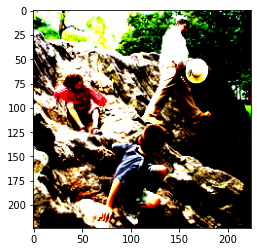

Actual Sentence two boys and a man holding a white hat climb on a rock with a lawn and shade trees visible in the background
Predicted Sentence two people are sitting on a dock near a lake
Bleu Score 0.7641166194509462
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /conten

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


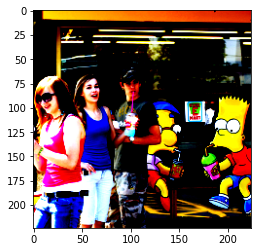

Actual Sentence four young people with cold drinks stand on the sidewalk in front of cutouts of the also holding cold drinks
Predicted Sentence a group of people are standing in a field of colorful flowers
Bleu Score 0.726573864061911
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


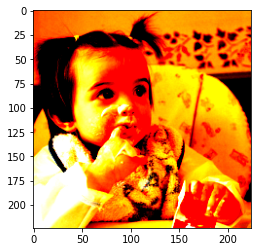

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Sentence a baby girl holding a red plastic box in one hand and eating from it with the other some of it on her face
Predicted Sentence a baby is holding a spoon of a spoon
Bleu Score 0.7896895367562644
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


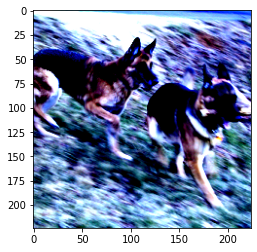

Actual Sentence a german shepherd dog is running behind another german shepherd dog that is carrying a stick in its mouth
Predicted Sentence a black dog and a brown dog in a grassy field
Bleu Score 0.7468422531048421
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


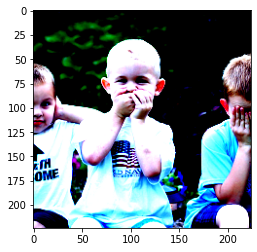

Actual Sentence the little boy covering his mouth is sitting between a covering his eyes and another boy covering his ears
Predicted Sentence two young boys are playing in a sprinkler
Bleu Score 0.7777264164917724
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


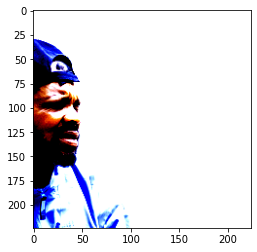

Actual Sentence a man with a beard and a navy blue backwards baseball cap stares intently at something in the distance
Predicted Sentence a man wearing a black shirt and a woman in a pink dress
Bleu Score 0.7666510377252865
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


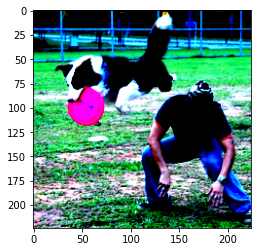

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Sentence a brown and white dog with a pink frisbee in its mouth leaps through the air next to a young man in a knit cap
Predicted Sentence a dog leaps over a hurdle
Bleu Score 0.8323582900575635
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


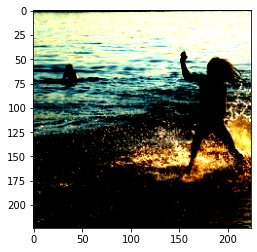

Actual Sentence a person is standing in water with it splashing all around them while another person in the background
Predicted Sentence a man is throwing a stick in the water
Bleu Score 0.7926416986492341
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


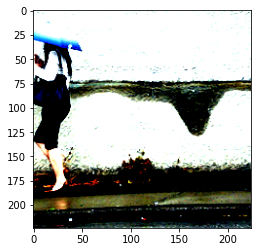

Actual Sentence a woman in heels black skirt and white shirt holds her blue umbrella over her head while walking on a sidewalk near a parking meter
Predicted Sentence a man is sitting on a bench next to a tree
Bleu Score 0.7598356856515925
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


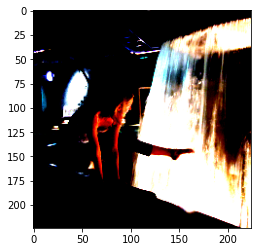

Actual Sentence a woman in jeans crouches on the edge of a fountain with her left foot kicked out to touch the falling water
Predicted Sentence a girl in a bathing suit is swinging on a swing
Bleu Score 0.725205974975922
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


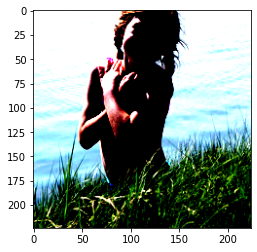

Actual Sentence a little girl in a swimsuit and braids is in front of the water in the grass with her arms crossed in front of her chest
Predicted Sentence a young girl wearing a pink hat and white shorts is standing in the water
Bleu Score 0.6732743971900496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


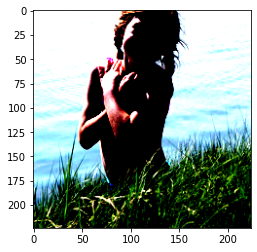

Actual Sentence girl with arms crossed over her heart wearing a bikini setting in tall grass in front of a body of water
Predicted Sentence a young girl wearing a pink hat and white shorts is standing in the water
Bleu Score 0.684225539412643
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


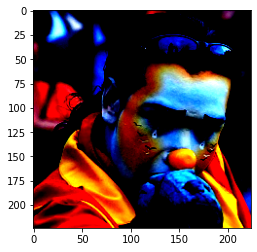

Actual Sentence a man with black hair is wearing a red and yellow shirt and has a yellow clown nose and face makeup on
Predicted Sentence a boy with a red shirt is playing in a sprinkler
Bleu Score 0.7825422900366437
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


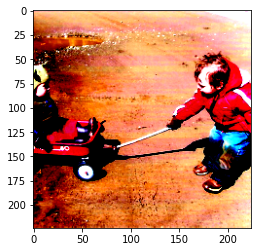

Actual Sentence a toddler in a red jacket and jeans pulling another toddler wearing a green hat and jacket and red paints in a red wagon
Predicted Sentence a man in a blue shirt and blue shorts is jumping into a pool
Bleu Score 0.7186082239261684
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


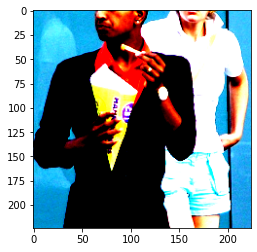

Actual Sentence the man white purple and white shirts is eating and looking to his right while the woman behind him has a look on her face
Predicted Sentence a woman in a blue shirt is smiling at a table with a baby in a hospital
Bleu Score 0.6995159848980531
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


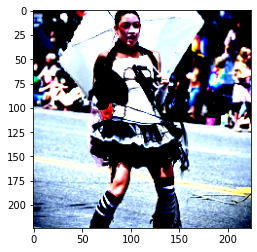

Actual Sentence a girl dressed in black and white with makeup stands in the middle of a street with a white umbrella and black top hat in her hand
Predicted Sentence a woman in a blue dress is walking next to a man in a blue shirt
Bleu Score 0.7282376575609851
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


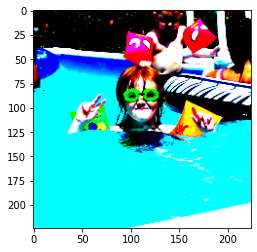

Actual Sentence a red haired girl making a peace sign is wearing neon green glasses and floaties and playing in the pool with other kids
Predicted Sentence a girl in a bathing suit is throwing a ball in a pool
Bleu Score 0.7037475090852178
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt
Epoch /content/drive/My Drive/Colab Notebooks/RNN/encoder5.ckpt


In [33]:
blue_scores = []
for i, (images, targets, lengths) in enumerate(test_loader): # Iterating the test data loader
  image = images.to(device)
  #image_features = encoder(image)
  test_encoder.eval()
  test_decoder.eval()

#test_image = load_image(image_dir + "1007320043_627395c3d8.jpg", transform)
#test_image = test_image.to(device)
  print ("Epoch", file_encoder)
  sample_feature = test_encoder(image)
  sampled_ids = test_decoder.sample(sample_feature)
  sampled_ids = sampled_ids[0].cpu().numpy()
  #sampled_ids = decoder.sample(image_features) 
  #sampled_ids = sampled_ids[0].cpu().data.numpy()
 # print (targets)
  targets = targets.cpu()
  targets = targets.tolist()
  #print (len(targets))

 
  for i in range(len(targets)):
    referenced_ids = targets[i]
    reference_sentence = get_sentence(referenced_ids)
    if len(reference_sentence) > 100:
      
      
      img = image.cpu().numpy()
      plt.imshow(np.transpose(img[0], (1,2,0)))
      plt.show()
      predicted_sentence = get_sentence(sampled_ids)
      bleu_score = sentence_bleu(reference_sentence, predicted_sentence)
    
      print("Actual Sentence",reference_sentence)
      predicted_sentence = get_sentence(sampled_ids)
      print("Predicted Sentence",predicted_sentence)
      print("Bleu Score",bleu_score)
    
      blue_scores.append(bleu_score)
  

  #Displaying image

  #plt.show()
  
#


In [37]:
print (" BLEU Avg-score ",sum(blue_scores)/len(blue_scores))

 BLEU Avg-score  0.761821008697629
